In [1]:
from importlib import reload
from itertools import chain

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from evaluation import evaluator

reload(evaluator)

<module 'evaluation.evaluator' from '/home/alex/code/ML/ML24/exercise-1/evaluation/evaluator.py'>

# Preprocessing

In [2]:
data = arff.loadarff('./datasets/credit-g/dataset_31_credit-g.arff')
data = pd.DataFrame(data[0])

for column in data.columns:
    # replace missing values with pd.NA
    data[column] = data[column].replace(b'?', pd.NA)
    data[column] = data[column].replace(b'', pd.NA)
    data[column] = data[column].replace(b'NONE', pd.NA)
    # decode bytes to string for each column
    data[column] = data[column].apply(lambda x: x.decode() if isinstance(x, bytes) else x)

In [3]:
data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,...,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes,good
996,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,...,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
997,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,...,car,38.0,none,own,1.0,skilled,1.0,none,yes,good
998,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,...,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes,bad


In [4]:
y = data[('class')] 
X = data.drop('class', axis=1)  # Features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print("null values in train data: "+ str(X_train.isnull().sum().sum()))
print("null values in test data: "+ str(X_test.isnull().sum().sum()))

null values in train data: 0
null values in test data: 0


In [6]:
# find all numerical columns in X_train
numerical_columns = X_train.select_dtypes(include="number").columns
# convert numerical columns to list
numerical_columns = numerical_columns.tolist()
numerical_columns

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [7]:
feature_mappings = {
    'checking_status': ['no checking', '<0', '0<=X<200', '>=200'],
    'saving_status': ['no known savings', '<100', '100<=X<500', '500<=X<1000', '>=1000'],
    'employment': ['unemployed', '<1', '1<=X<4', '4<=X<7', '>=7'],
    'own_telephone': ['none', 'yes'],
    'foreign_worker': ['no', 'yes'],
}

ordinal_columns = [col for col in X_train.columns if col in feature_mappings.keys()]
ordinal_categories = [feature_mappings[col] for col in ordinal_columns]
ordinal_columns

['checking_status', 'employment', 'own_telephone', 'foreign_worker']

In [8]:
categorical_columns = [col for col in X_train.columns if col not in ordinal_columns and col not in numerical_columns] 

one_hot_encoding_limit = 10
one_hot_columns = [col for col in categorical_columns if X_train[col].nunique() <= one_hot_encoding_limit]

label_columns = [col for col in categorical_columns if col not in one_hot_columns]

In [9]:
preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_columns),
    ('categorical', OneHotEncoder(handle_unknown="ignore"), one_hot_columns),
    ('label', OrdinalEncoder(), label_columns)
],
    remainder='passthrough'  # passthrough columns not listed in any pipeline
)

In [10]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MinMaxScaler())
])

pipeline_standard = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

X_train_std = pipeline_standard.fit_transform(X_train)
X_test_std = pipeline_standard.transform(X_test)

# Preprocess training data
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [11]:
# Encode target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Evaluation

## Neural Network

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 5000, 'verbose': False}
done with  hidden_layer_sizes   (7,)  results:  {'accuracy': 0.733, 'recall': 0.733, 'precision': 0.7352504871728389, 'f1': 0.7331822627084521, 'time': 698.7373352050781, 'hidden_layer_sizes': (7,)}
done with  hidden_layer_sizes   (7, 7)  results:  {'accuracy': 0.7005, 'recall': 0.7004999999999999, 'precision': 0.7061084261344639, 'f1': 0.7025862534003997, 'time': 906.2314987182617, 'hidden_layer_sizes': (7, 7)}
done with  hidden_layer_sizes   (7, 7, 7)  results:  {'accuracy': 0.6769999999999999, 'recall': 0.677, 'precision': 0.6867184121194192, 'f1': 0.6807397219721708, 'time': 1031.8874835968018, 'hidden_layer_sizes': (7, 7, 7)}
done with  hidden_layer_sizes   (7, 7, 7, 7)  results:  {'accuracy': 0.669, 'recall': 0.6689999999999998, 'precision': 0.6732220017543101, 'f1': 0.6701346431165046, 'time': 838.4644031524658, 'hidden

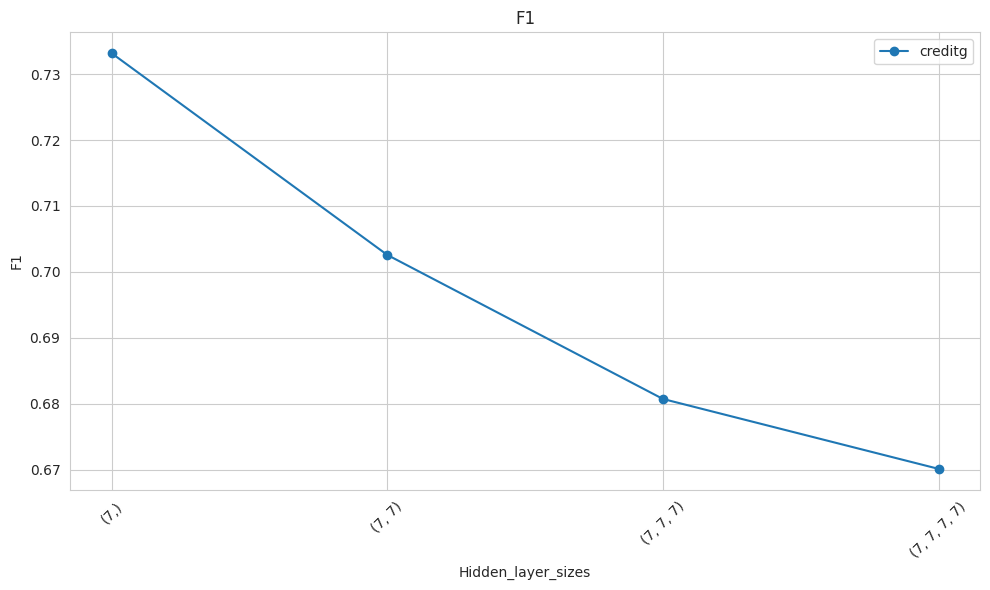

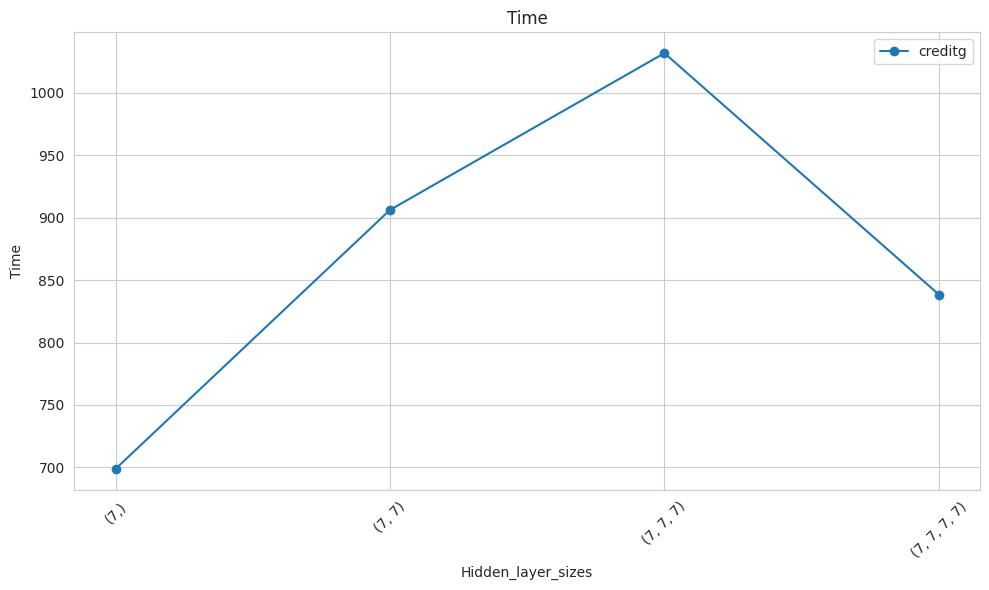

In [12]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    #'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    'max_iter': 5000,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'hidden_layer_sizes': [(7, ), (7, 7), (7, 7, 7), (7, 7, 7, 7),]}
nn_hidden_layer_deepness = evaluator.evaluate2_mean(MLPClassifier, X_train_std, y_train, X_test_std, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=10)
evaluator.draw_diagram2_list({"creditg": nn_hidden_layer_deepness}, x_axis='hidden_layer_sizes', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 5000, 'verbose': False}
done with  hidden_layer_sizes   (1, 1)  results:  {'accuracy': 0.698, 'recall': 0.6980000000000001, 'precision': 0.5790409292730214, 'f1': 0.6247796733407233, 'time': 186.66210174560547, 'hidden_layer_sizes': (1, 1)}
done with  hidden_layer_sizes   (2, 2)  results:  {'accuracy': 0.727, 'recall': 0.727, 'precision': 0.7288634567250712, 'f1': 0.7267927956636375, 'time': 342.4910068511963, 'hidden_layer_sizes': (2, 2)}
done with  hidden_layer_sizes   (3, 3)  results:  {'accuracy': 0.714, 'recall': 0.7139999999999999, 'precision': 0.7084328173366223, 'f1': 0.7065494597206031, 'time': 433.2707405090332, 'hidden_layer_sizes': (3, 3)}
done with  hidden_layer_sizes   (4, 4)  results:  {'accuracy': 0.726, 'recall': 0.726, 'precision': 0.7201699463291711, 'f1': 0.7211903133336166, 'time': 630.3121089935303, 'hidden_layer_sizes': (4, 4)}

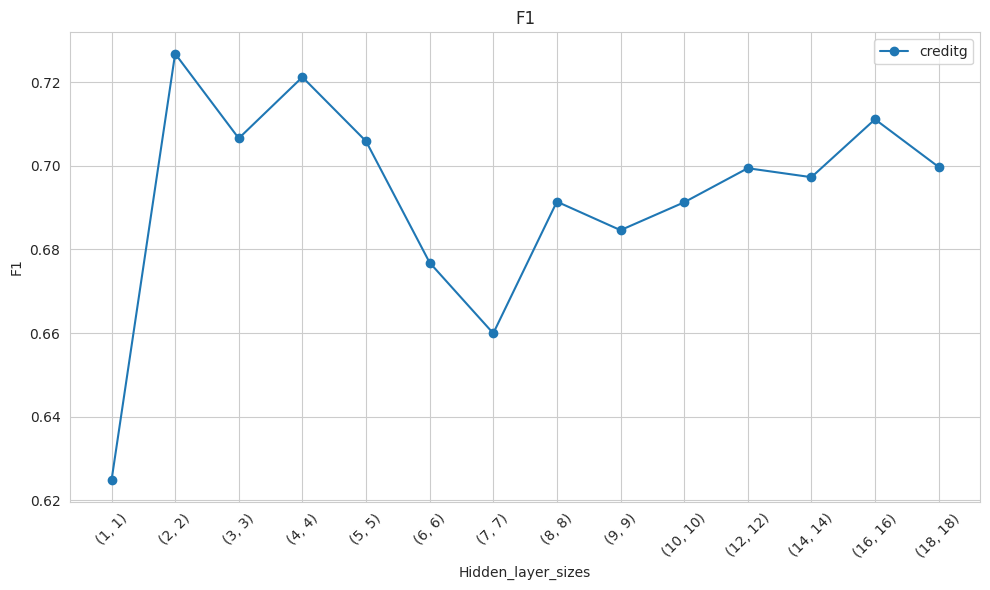

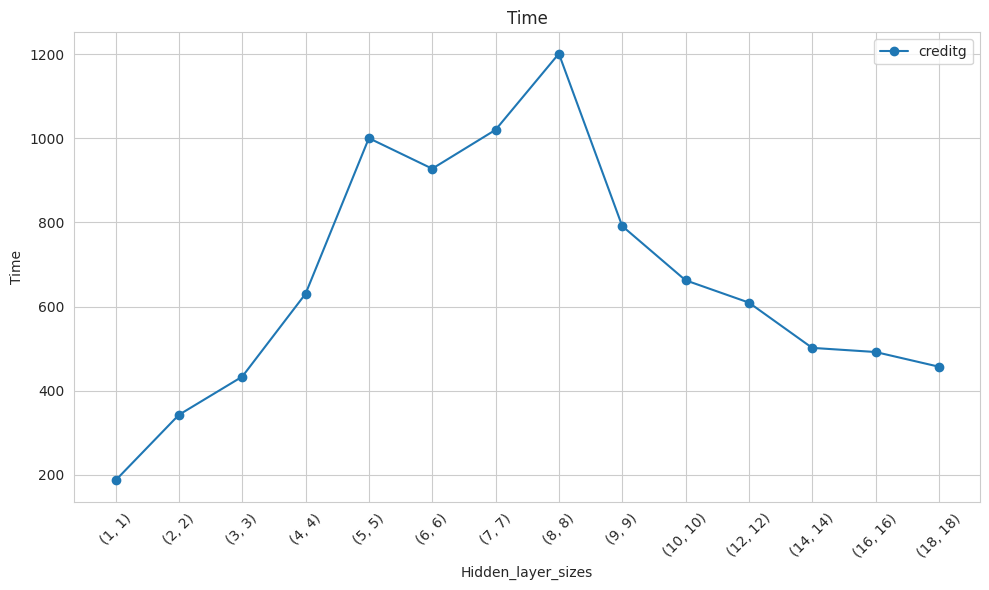

In [13]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    #'hidden_layer_sizes': (15, 15, 15),
    #'random_state': 7895,
    'max_iter': 5000,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'hidden_layer_sizes': [(i, i) for i in chain(range(1, 10, 1), range(10, 20, 2))]}
nn_hidden_layer = evaluator.evaluate2_mean(MLPClassifier, X_train_std, y_train, X_test_std, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=5)
evaluator.draw_diagram2_list({"creditg": nn_hidden_layer}, x_axis='hidden_layer_sizes', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'hidden_layer_sizes': (7,), 'max_iter': 1500, 'verbose': False}
done with  learning_rate_init   1e-06  results:  {'accuracy': 0.606, 'recall': 0.6060000000000001, 'precision': 0.46168968639110214, 'f1': 0.5097479224647803, 'time': 11.163806915283203, 'learning_rate_init': 1e-06}
done with  learning_rate_init   1.519911082952933e-06  results:  {'accuracy': 0.5479999999999999, 'recall': 0.5479999999999999, 'precision': 0.5703789044248422, 'f1': 0.45026496894662105, 'time': 8.234024047851562, 'learning_rate_init': 1.519911082952933e-06}
done with  learning_rate_init   2.310129700083158e-06  results:  {'accuracy': 0.46299999999999997, 'recall': 0.4630000000000001, 'precision': 0.5819780568626032, 'f1': 0.4385077372630537, 'time': 7.823610305786133, 'learning_rate_init': 2.310129700083158e-06}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   3.5111917342151275e-06  results:  {'accuracy': 0.43600000000000005, 'recall': 0.43599999999999994, 'precision': 0.6088727742581044, 'f1': 0.3634867762292592, 'time': 333.85777473449707, 'learning_rate_init': 3.5111917342151275e-06}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   5.336699231206313e-06  results:  {'accuracy': 0.607, 'recall': 0.607, 'precision': 0.47309480981459356, 'f1': 0.5158579267029773, 'time': 309.6247673034668, 'learning_rate_init': 5.336699231206313e-06}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   8.111308307896873e-06  results:  {'accuracy': 0.492, 'recall': 0.492, 'precision': 0.4835202544823319, 'f1': 0.42908720320040217, 'time': 418.9476013183594, 'learning_rate_init': 8.111308307896873e-06}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   1.2328467394420658e-05  results:  {'accuracy': 0.583, 'recall': 0.583, 'precision': 0.5809452500934351, 'f1': 0.5342088765772337, 'time': 543.3455944061279, 'learning_rate_init': 1.2328467394420658e-05}
done with  learning_rate_init   1.873817422860383e-05  results:  {'accuracy': 0.6910000000000001, 'recall': 0.6910000000000001, 'precision': 0.5459957843505242, 'f1': 0.6004381590802901, 'time': 225.44240951538086, 'learning_rate_init': 1.873817422860383e-05}
done with  learning_rate_init   2.8480358684358048e-05  results:  {'accuracy': 0.696, 'recall': 0.696, 'precision': 0.5921233830487491, 'f1': 0.6031122981253307, 'time': 256.3176155090332, 'learning_rate_init': 2.8480358684358048e-05}
done with  learning_rate_init   4.328761281083062e-05  results:  {'accuracy': 0.698, 'recall': 0.698, 'precision': 0.5209872136892488, 'f1': 0.5882193349208876, 'time': 355.2976608276367, 'learning_rate_init': 4.328761281083062e-05}
done with  learning_rate_init   6.579

/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: 

done with  learning_rate_init   0.0005336699231206312  results:  {'accuracy': 0.737, 'recall': 0.737, 'precision': 0.7279012208914265, 'f1': 0.7306350190991182, 'time': 782.67822265625, 'learning_rate_init': 0.0005336699231206312}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.0008111308307896872  results:  {'accuracy': 0.723, 'recall': 0.723, 'precision': 0.7200351828906065, 'f1': 0.7206668981281533, 'time': 726.7347812652588, 'learning_rate_init': 0.0008111308307896872}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: 

done with  learning_rate_init   0.0012328467394420659  results:  {'accuracy': 0.712, 'recall': 0.712, 'precision': 0.7114089830614738, 'f1': 0.71164007769918, 'time': 748.8346576690674, 'learning_rate_init': 0.0012328467394420659}


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


done with  learning_rate_init   0.001873817422860385  results:  {'accuracy': 0.713, 'recall': 0.7130000000000001, 'precision': 0.7123848358486166, 'f1': 0.7121761391076261, 'time': 599.4300365447998, 'learning_rate_init': 0.001873817422860385}
done with  learning_rate_init   0.002848035868435802  results:  {'accuracy': 0.723, 'recall': 0.7230000000000001, 'precision': 0.7244925279135581, 'f1': 0.7234958825043292, 'time': 534.5695495605469, 'learning_rate_init': 0.002848035868435802}
done with  learning_rate_init   0.004328761281083062  results:  {'accuracy': 0.723, 'recall': 0.723, 'precision': 0.7198189144149795, 'f1': 0.7205600011295827, 'time': 339.3195152282715, 'learning_rate_init': 0.004328761281083062}
done with  learning_rate_init   0.006579332246575682  results:  {'accuracy': 0.708, 'recall': 0.708, 'precision': 0.7068933226563868, 'f1': 0.7052552166932177, 'time': 236.25311851501465, 'learning_rate_init': 0.006579332246575682}
done with  learning_rate_init   0.01  results:  {

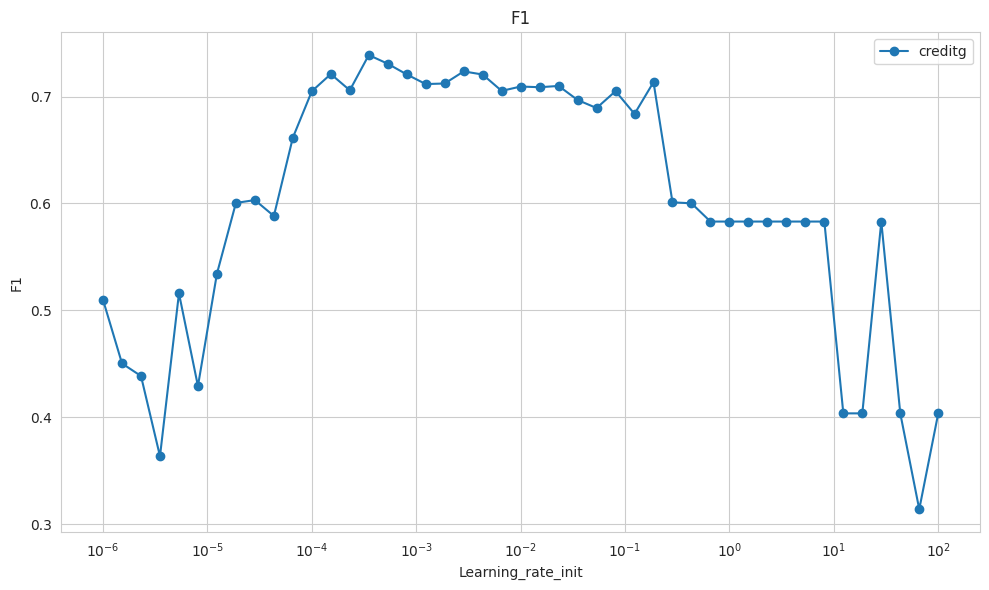

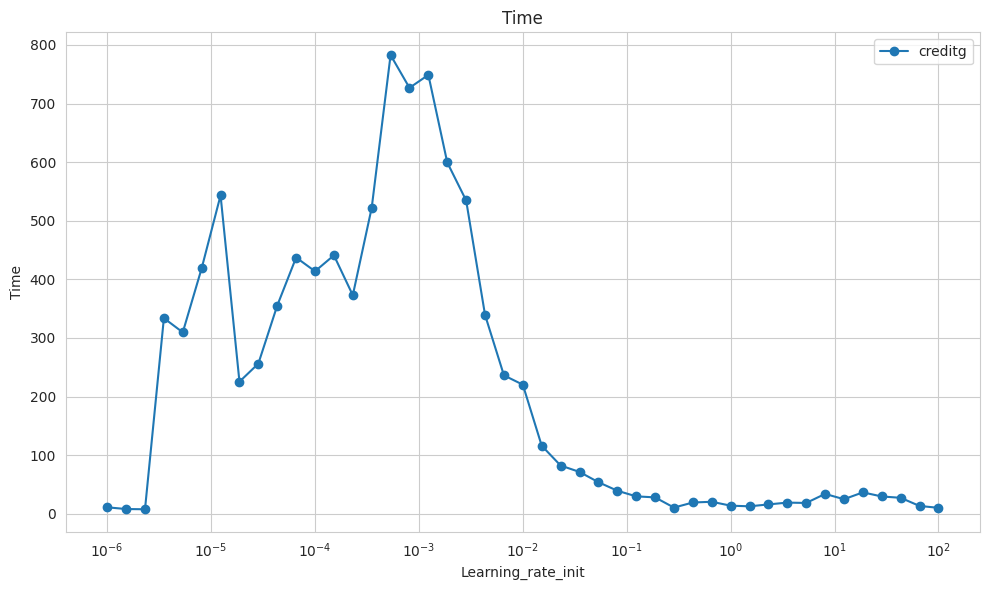

In [12]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'hidden_layer_sizes': (7,),
    #'random_state': 7895,
    'max_iter': 1500,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'learning_rate_init': np.logspace(-6, 2, num=45)}
nn_learning_rate = evaluator.evaluate2_mean(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=5)
evaluator.draw_diagram2_list({"creditg": nn_learning_rate}, x_axis='learning_rate_init', y_axis=['f1', 'time'], logaritmic=True)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (7,), 'verbose': False}
Hyperparameter  max_iter  value:  50
Accuracy:  0.72
Recall:  0.72
Precision:  0.6885187914517317
F1:  0.6743856419696272
Time: 26.192904ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  13 |  46 |
|  1 |  10 | 131 |
+----+-----+-----+
Hyperparameter  max_iter  value:  75
Accuracy:  0.72
Recall:  0.72
Precision:  0.6942657342657342
F1:  0.6501897018970189
Time: 38.189173ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |   8 |  51 |
|  1 |   5 | 136 |
+----+-----+-----+
Hyperparameter  max_iter  value:  100
Accuracy:  0.75
Recall:  0.75
Precision:  0.7326302729528535
F1:  0.7224014336917562
Time: 50.211430ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  20 |  39 |
|  1 |  11 | 130 

/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stoch

Hyperparameter  max_iter  value:  150
Accuracy:  0.75
Recall:  0.75
Precision:  0.7351873796474596
F1:  0.7371035662587182
Time: 77.542782ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  17 | 124 |
+----+-----+-----+
Hyperparameter  max_iter  value:  175
Accuracy:  0.74
Recall:  0.74
Precision:  0.7224942475839853
F1:  0.7243999999999999
Time: 87.778568ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  24 |  35 |
|  1 |  17 | 124 |
+----+-----+-----+
Hyperparameter  max_iter  value:  200
Accuracy:  0.755
Recall:  0.755
Precision:  0.7395625
F1:  0.7392224571294339
Time: 99.297523ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  25 |  34 |
|  1 |  15 | 126 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (225) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  225
Accuracy:  0.745
Recall:  0.745
Precision:  0.7262228997289972
F1:  0.7237463330457291
Time: 112.481594ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  22 |  37 |
|  1 |  14 | 127 |
+----+-----+-----+
Hyperparameter  max_iter  value:  250
Accuracy:  0.76
Recall:  0.76
Precision:  0.7457524160147263
F1:  0.7456
Time: 123.471022ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  15 | 126 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (275) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  275
Accuracy:  0.74
Recall:  0.74
Precision:  0.7253476702508961
F1:  0.7286486486486488
Time: 136.924505ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  19 | 122 |
+----+-----+-----+
Hyperparameter  max_iter  value:  300
Accuracy:  0.73
Recall:  0.73
Precision:  0.7161326658322903
F1:  0.7202271852137082
Time: 147.287130ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  21 | 120 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (325) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  325
Accuracy:  0.715
Recall:  0.715
Precision:  0.7033
F1:  0.7076411614489738
Time: 162.131071ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  24 | 117 |
+----+-----+-----+
Hyperparameter  max_iter  value:  350
Accuracy:  0.705
Recall:  0.705
Precision:  0.6852884615384616
F1:  0.6909689124252231
Time: 175.002098ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  22 |  37 |
|  1 |  22 | 119 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (375) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  375
Accuracy:  0.71
Recall:  0.71
Precision:  0.7044576802507837
F1:  0.7069402527297264
Time: 191.299915ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  400
Accuracy:  0.755
Recall:  0.755
Precision:  0.7474870062370063
F1:  0.7502419028024563
Time: 203.264475ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  21 | 120 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (425) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  425
Accuracy:  0.735
Recall:  0.735
Precision:  0.7245
F1:  0.7281575711718529
Time: 216.336489ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  22 | 119 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  450
Accuracy:  0.74
Recall:  0.74
Precision:  0.7351347962382445
F1:  0.7372567783094099
Time: 228.658438ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  24 | 117 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (475) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  475
Accuracy:  0.745
Recall:  0.745
Precision:  0.739146372399797
F1:  0.7415796614350466
Time: 239.637613ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  23 | 118 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  500
Accuracy:  0.755
Recall:  0.755
Precision:  0.7456999999999999
F1:  0.7486739808947318
Time: 254.628658ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  30 |  29 |
|  1 |  20 | 121 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (525) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  525
Accuracy:  0.71
Recall:  0.71
Precision:  0.7018136311128225
F1:  0.7052529761904762
Time: 264.089584ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  26 | 115 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (550) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  550
Accuracy:  0.78
Recall:  0.78
Precision:  0.7728622187129887
F1:  0.7750344827586207
Time: 274.733305ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  33 |  26 |
|  1 |  18 | 123 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (575) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  575
Accuracy:  0.745
Recall:  0.745
Precision:  0.7333004385964912
F1:  0.7366792127842811
Time: 284.578323ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  20 | 121 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  600
Accuracy:  0.735
Recall:  0.735
Precision:  0.7189597902097903
F1:  0.7223958026870649
Time: 295.878172ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  25 |  34 |
|  1 |  19 | 122 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (625) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  625
Accuracy:  0.695
Recall:  0.695
Precision:  0.6965119047619046
F1:  0.6957388079787076
Time: 311.499596ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  31 | 110 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (650) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  650
Accuracy:  0.76
Recall:  0.76
Precision:  0.76
F1:  0.76
Time: 323.299885ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  35 |  24 |
|  1 |  24 | 117 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (675) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  675
Accuracy:  0.73
Recall:  0.73
Precision:  0.7161326658322903
F1:  0.7202271852137082
Time: 331.075430ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  21 | 120 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  700
Accuracy:  0.72
Recall:  0.72
Precision:  0.6974486383182036
F1:  0.7007000946073794
Time: 346.532106ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  21 |  38 |
|  1 |  18 | 123 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (725) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  725
Accuracy:  0.73
Recall:  0.73
Precision:  0.72739663844927
F1:  0.7286231180184557
Time: 361.768246ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  26 | 115 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  750
Accuracy:  0.755
Recall:  0.755
Precision:  0.7494381024860476
F1:  0.7517137923591625
Time: 372.830391ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  32 |  27 |
|  1 |  22 | 119 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (775) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  775
Accuracy:  0.75
Recall:  0.75
Precision:  0.7432614555256065
F1:  0.7459077380952381
Time: 386.065960ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  22 | 119 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  800
Accuracy:  0.72
Recall:  0.72
Precision:  0.7097670746150808
F1:  0.713680250783699
Time: 396.816492ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  24 | 117 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (825) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  825
Accuracy:  0.725
Recall:  0.725
Precision:  0.7139
F1:  0.7178993663104134
Time: 406.372786ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  23 | 118 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (850) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  850
Accuracy:  0.755
Recall:  0.755
Precision:  0.7474870062370063
F1:  0.7502419028024563
Time: 421.324492ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  21 | 120 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (875) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  875
Accuracy:  0.75
Recall:  0.75
Precision:  0.7453605015673981
F1:  0.7473622868359711
Time: 429.332018ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  32 |  27 |
|  1 |  23 | 118 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  900
Accuracy:  0.725
Recall:  0.725
Precision:  0.7185629122272958
F1:  0.7213113995868151
Time: 449.408293ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  25 | 116 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (925) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  925
Accuracy:  0.725
Recall:  0.725
Precision:  0.7236583292860612
F1:  0.7243106520491679
Time: 460.420132ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (950) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  950
Accuracy:  0.715
Recall:  0.715
Precision:  0.7033
F1:  0.7076411614489738
Time: 467.892885ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  26 |  33 |
|  1 |  24 | 117 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (975) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  975
Accuracy:  0.725
Recall:  0.725
Precision:  0.7096767363071712
F1:  0.7140355125100888
Time: 487.845659ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  25 |  34 |
|  1 |  21 | 120 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1000
Accuracy:  0.71
Recall:  0.71
Precision:  0.7071856213961476
F1:  0.7085211267605636
Time: 497.444630ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  28 | 113 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1025) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1025
Accuracy:  0.7
Recall:  0.7
Precision:  0.7
F1:  0.7
Time: 508.682251ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  29 |  30 |
|  1 |  30 | 111 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1050) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1050
Accuracy:  0.725
Recall:  0.725
Precision:  0.7236583292860612
F1:  0.7243106520491679
Time: 522.510290ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  27 | 114 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1075) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1075
Accuracy:  0.705
Recall:  0.705
Precision:  0.7007291666666666
F1:  0.7027048054919908
Time: 539.555550ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  28 | 113 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1100
Accuracy:  0.715
Recall:  0.715
Precision:  0.7082711821410451
F1:  0.7111772686626994
Time: 959.949017ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  28 |  31 |
|  1 |  26 | 115 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1125) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1125
Accuracy:  0.755
Recall:  0.755
Precision:  0.7474870062370063
F1:  0.7502419028024563
Time: 546.349049ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  31 |  28 |
|  1 |  21 | 120 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1150) reached and the optimization hasn't converged yet.
  warnings.warn(


Hyperparameter  max_iter  value:  1150
Accuracy:  0.715
Recall:  0.715
Precision:  0.7057406444906446
F1:  0.7094650706069391
Time: 561.160803ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  27 |  32 |
|  1 |  25 | 116 |
+----+-----+-----+
Hyperparameter  max_iter  value:  1175
Accuracy:  0.745
Recall:  0.745
Precision:  0.7370504158004159
F1:  0.740047694753577
Time: 590.709209ms
Confusion Matrix: 
+----+-----+-----+
|    |   0 |   1 |
|----+-----+-----|
|  0 |  30 |  29 |
|  1 |  22 | 119 |
+----+-----+-----+


/home/alex/.cache/pypoetry/virtualenvs/ml24-cRmhZNh3-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1175) reached and the optimization hasn't converged yet.
  warnings.warn(


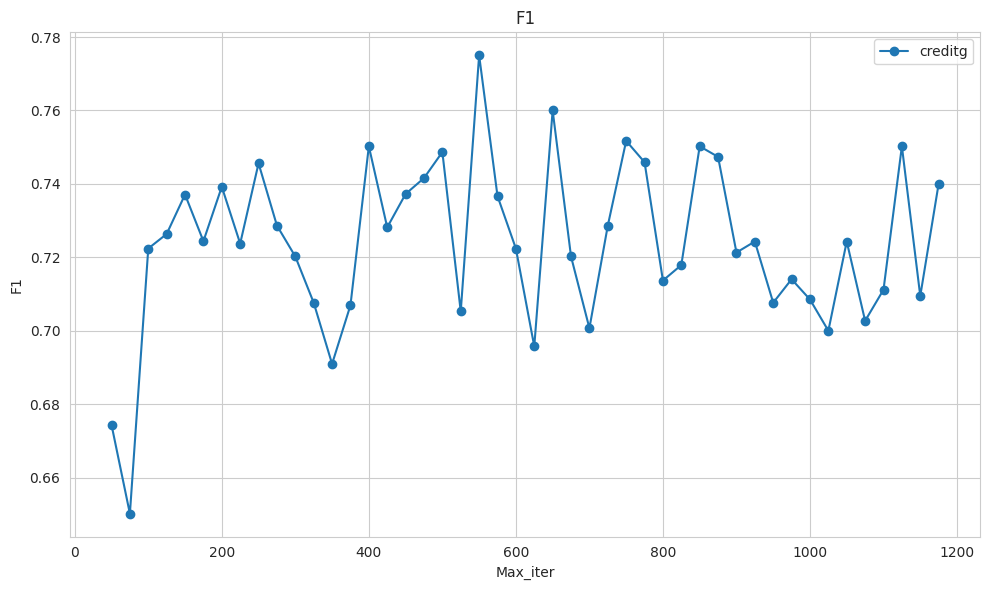

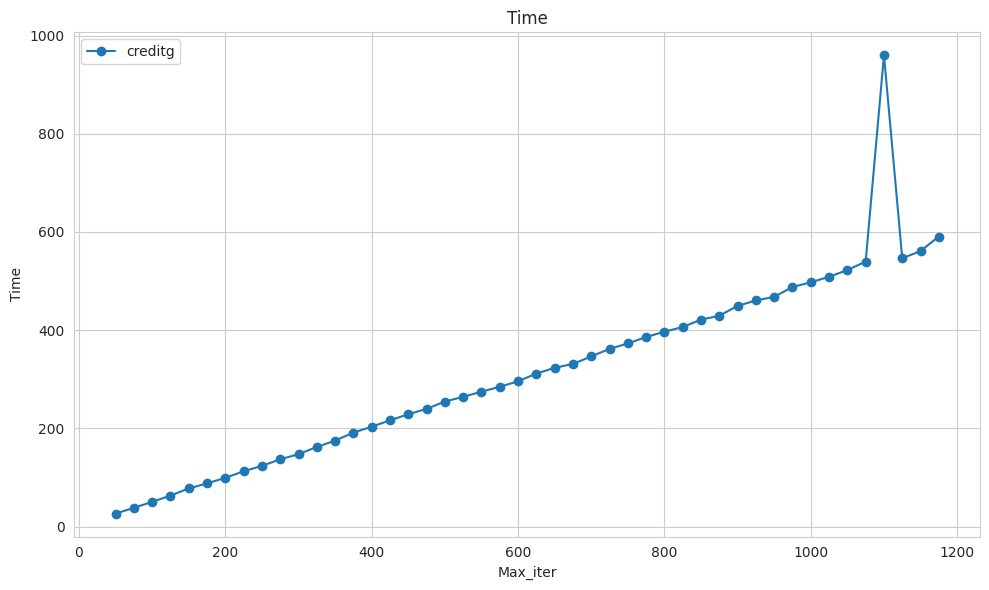

In [15]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-3,
    'hidden_layer_sizes': (7,),
    #'random_state': 7895,
    #'max_iter': 800,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'max_iter': range(50, 1200, 25)}
nn_max_iter = evaluator.evaluate2(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator)
evaluator.draw_diagram2_list({"creditg": nn_max_iter}, x_axis='max_iter', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (7,), 'max_iter': 3000, 'verbose': False}
done with  activation   identity  results:  {'accuracy': 0.752, 'recall': 0.752, 'precision': 0.737290380643767, 'f1': 0.7387719720362773, 'time': 108.32171440124512, 'activation': 'identity'}
done with  activation   logistic  results:  {'accuracy': 0.7344999999999999, 'recall': 0.7345, 'precision': 0.7208731516914724, 'f1': 0.7245824347316321, 'time': 252.93538570404053, 'activation': 'logistic'}
done with  activation   tanh  results:  {'accuracy': 0.6945, 'recall': 0.6945, 'precision': 0.6953444793332626, 'f1': 0.6943212505566932, 'time': 1263.4437322616577, 'activation': 'tanh'}
done with  activation   relu  results:  {'accuracy': 0.7304999999999999, 'recall': 0.7305, 'precision': 0.7253400526419975, 'f1': 0.7269646899383139, 'time': 941.4352655410767, 'activation': 'relu'}


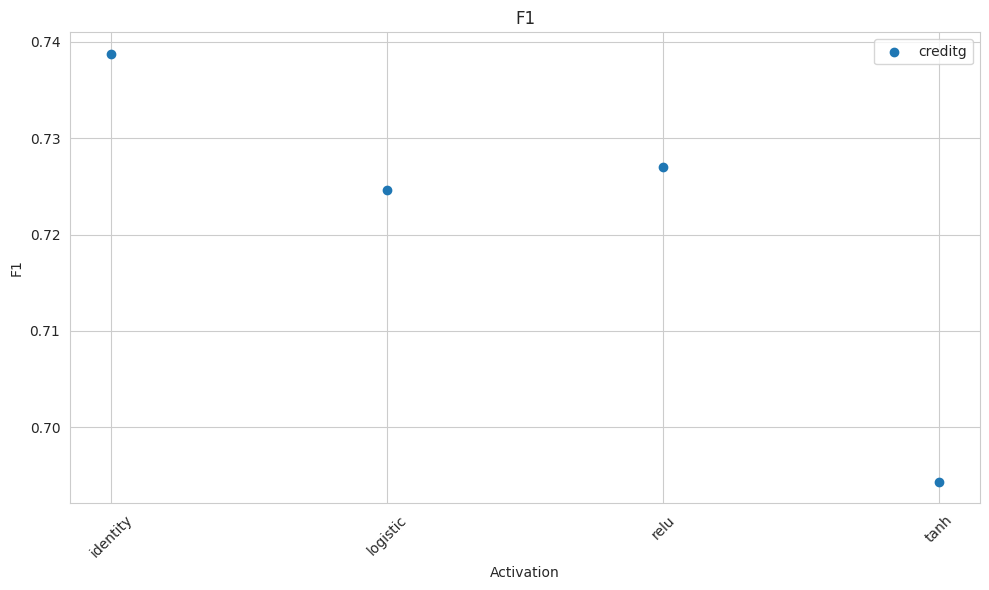

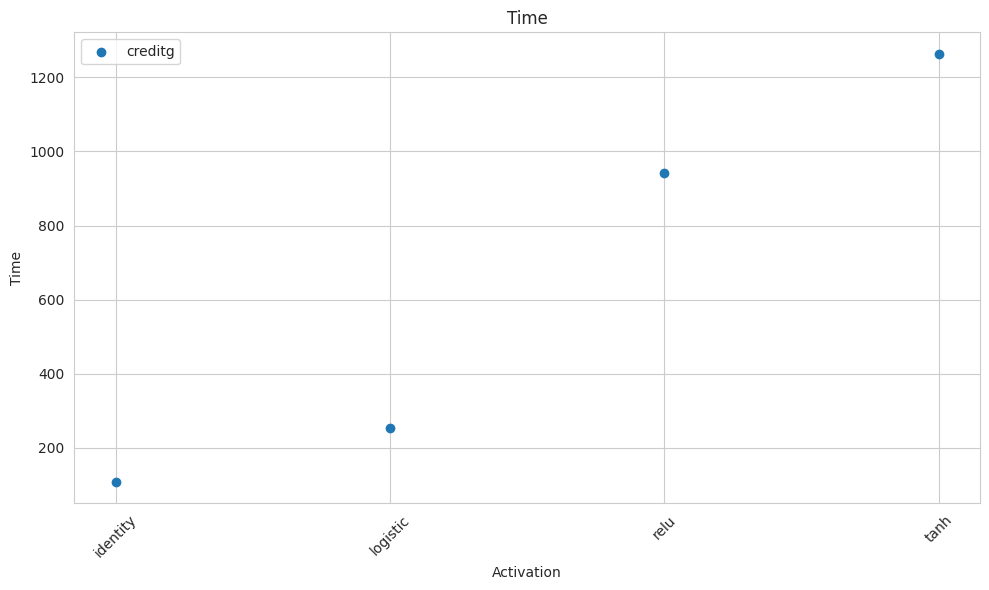

In [16]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    #'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-3,
    'hidden_layer_sizes': (7,),
    #'random_state': 7895,
    'max_iter': 3000,
    'verbose': False,
    #'tol': 5e-5
}
hyperparameters_iterator = {'activation': ['identity', 'logistic', 'tanh', 'relu']}
act_function1 = evaluator.evaluate2_mean(MLPClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                                    hyperparameters_iterate=hyperparameters_iterator, number_of_tests=10)
evaluator.draw_diagram2_list({"creditg": act_function1,},
                             x_axis='activation', y_axis=['f1', 'time'],
                             logaritmic=False, line=False)

## Random Forest

Evaluating classifier:  RandomForestClassifier
Hyperparameters:  {'criterion': 'gini', 'verbose': False}
done with  n_estimators   1  results:  {'accuracy': 0.67, 'recall': 0.6699999999999999, 'precision': 0.6685168441769848, 'f1': 0.6685153118103301, 'time': 2.0723342895507812, 'n_estimators': 1}
done with  n_estimators   2  results:  {'accuracy': 0.591, 'recall': 0.591, 'precision': 0.6761260831443686, 'f1': 0.6087264359391154, 'time': 2.8625965118408203, 'n_estimators': 2}
done with  n_estimators   3  results:  {'accuracy': 0.715, 'recall': 0.7149999999999999, 'precision': 0.7060786273729465, 'f1': 0.7090116786247591, 'time': 3.8336753845214844, 'n_estimators': 3}
done with  n_estimators   4  results:  {'accuracy': 0.6779999999999999, 'recall': 0.678, 'precision': 0.7100084635530803, 'f1': 0.6875369682286602, 'time': 4.865932464599609, 'n_estimators': 4}
done with  n_estimators   5  results:  {'accuracy': 0.73, 'recall': 0.73, 'precision': 0.7164601812231421, 'f1': 0.720040362019966

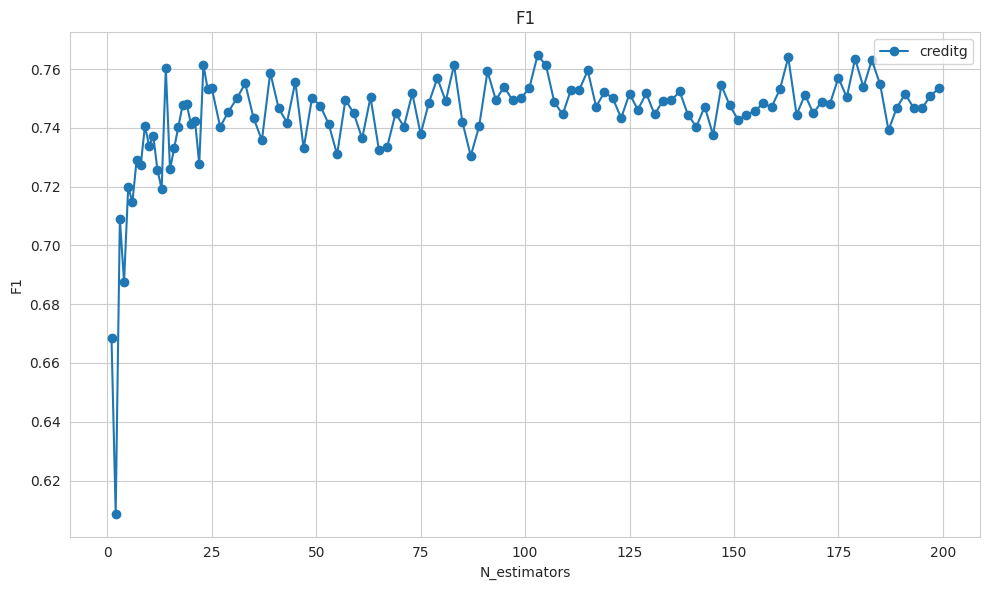

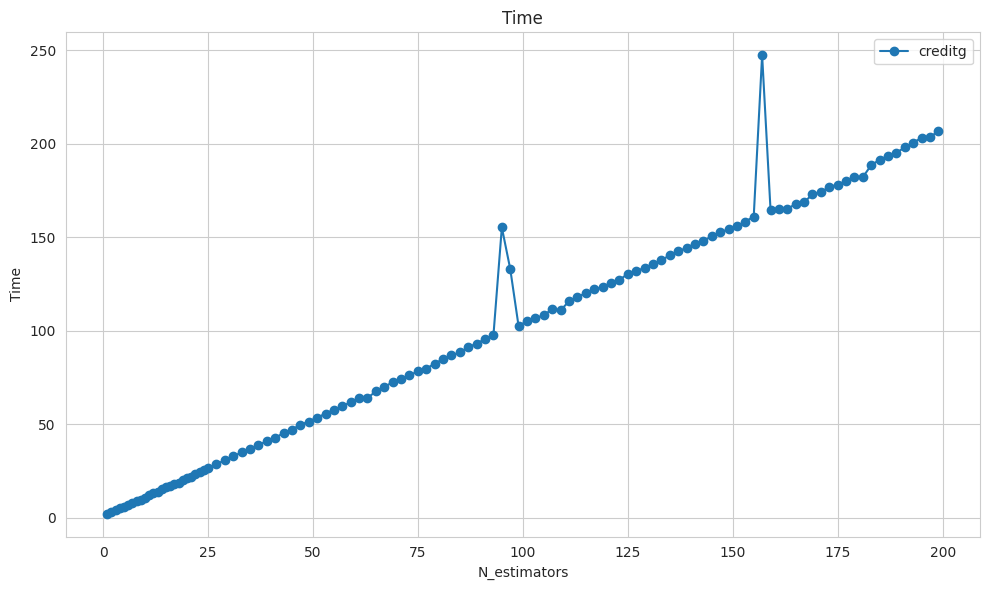

In [17]:
from itertools import chain

hyperparameters = {
    #'n_estimators': 100,
    'criterion': 'gini', # entropy, log_loss
    'verbose': False,
}
hyperparameters_iterator = {'n_estimators': chain(range(1, 25, 1), range(25, 200, 2))}
rf_n_estimators = evaluator.evaluate2_mean(RandomForestClassifier, X_train, y_train, X_test, y_test, hyperparameters=hyperparameters,
                           hyperparameters_iterate=hyperparameters_iterator, number_of_tests=5)
evaluator.draw_diagram2_list({"creditg": rf_n_estimators}, x_axis='n_estimators', y_axis=['f1', 'time'], logaritmic=False)

Evaluating classifier:  RandomForestClassifier
Hyperparameters:  {'n_estimators': 5, 'verbose': False}
done with  criterion   gini  results:  {'accuracy': 0.7199500000000001, 'recall': 0.7199499999999999, 'precision': 0.7051723015200383, 'f1': 0.7089082698738064, 'time': 5.920894145965576, 'criterion': 'gini'}
done with  criterion   entropy  results:  {'accuracy': 0.7295, 'recall': 0.7294999999999997, 'precision': 0.7153797860008905, 'f1': 0.7184804497256182, 'time': 5.872011184692383, 'criterion': 'entropy'}
done with  criterion   log_loss  results:  {'accuracy': 0.72685, 'recall': 0.72685, 'precision': 0.7121465232079929, 'f1': 0.7152110409303654, 'time': 5.894222259521484, 'criterion': 'log_loss'}


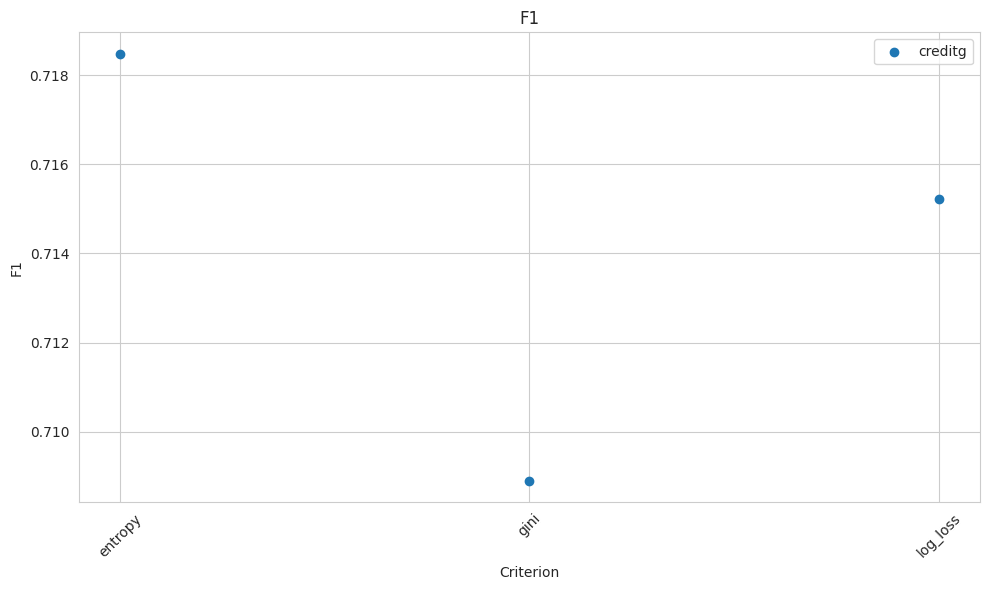

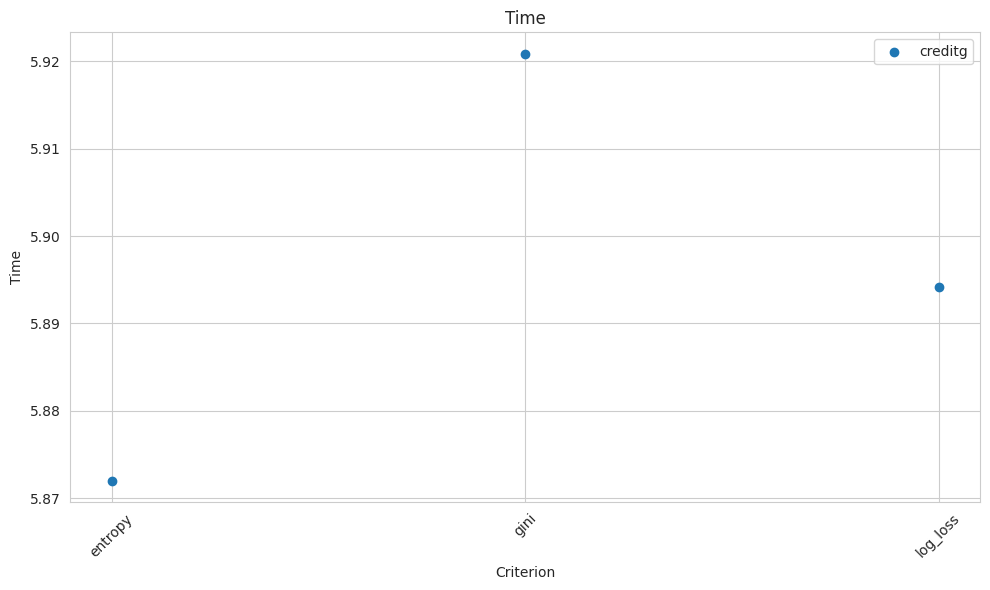

In [18]:
reload(evaluator)
hyperparameters = {
    'n_estimators': 5,
    #'criterion': 'gini', # entropy, log_loss
    'verbose': False,
}
hyperparameters_iterator = {'criterion': ['gini', 'entropy', 'log_loss']}
rf_criterion = evaluator.evaluate2_mean(RandomForestClassifier, X_train, y_train, X_test, y_test,
                                        hyperparameters=hyperparameters,
                                        hyperparameters_iterate=hyperparameters_iterator, number_of_tests=100)

evaluator.draw_diagram2_list({"creditg": rf_criterion, }, x_axis='criterion', y_axis=['f1', 'time'], logaritmic=False,
                             line=False)

## Bayes

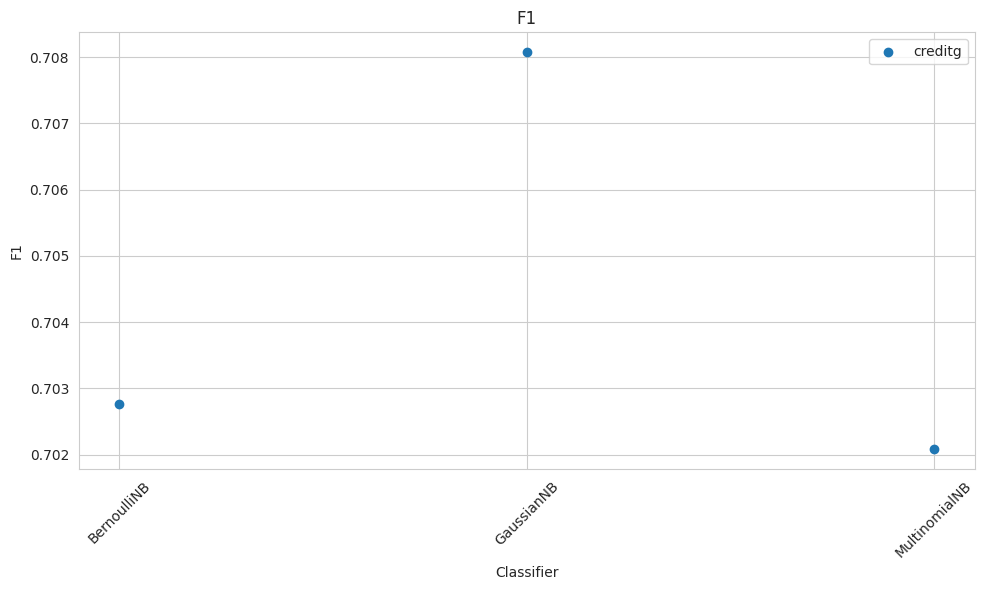

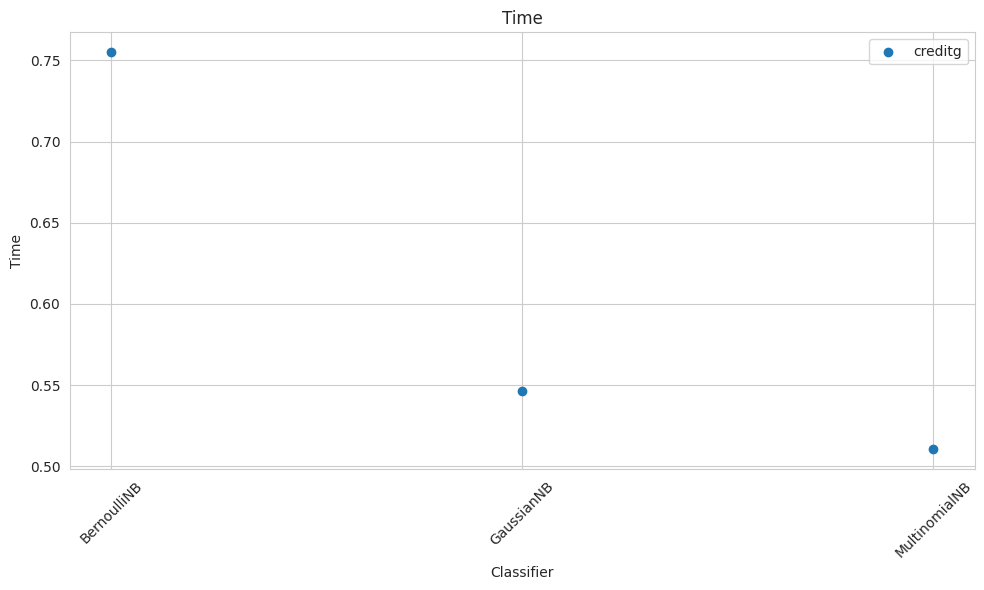

In [19]:
reload(evaluator)

classifiers = [GaussianNB, MultinomialNB, BernoulliNB]
names = ['GaussianNB', 'MultinomialNB', 'BernoulliNB']

bayes_results=evaluator.evaluate_classifier(classifiers, X_train, y_train, X_test, y_test, hyperparameters=[{},{},{},], names=names, number_of_tests=20)
evaluator.draw_diagram2_list({"creditg": bayes_results}, x_axis='classifier', y_axis=['f1', 'time'], logaritmic=False, line=False)

## evaluate scalers

Evaluating classifier:  MLPClassifier
Hyperparameters:  {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (7,), 'max_iter': 2500, 'verbose': False}


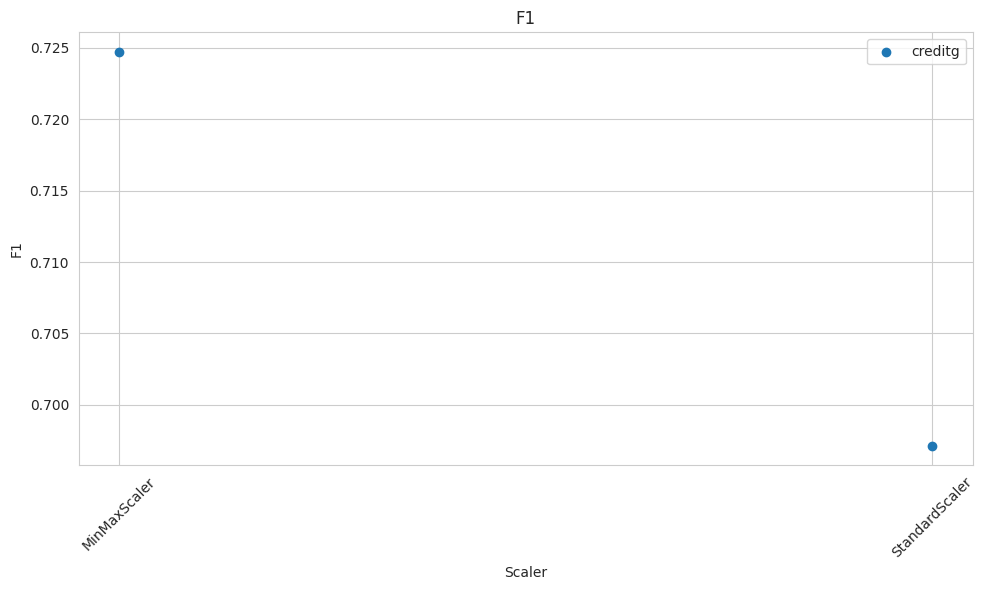

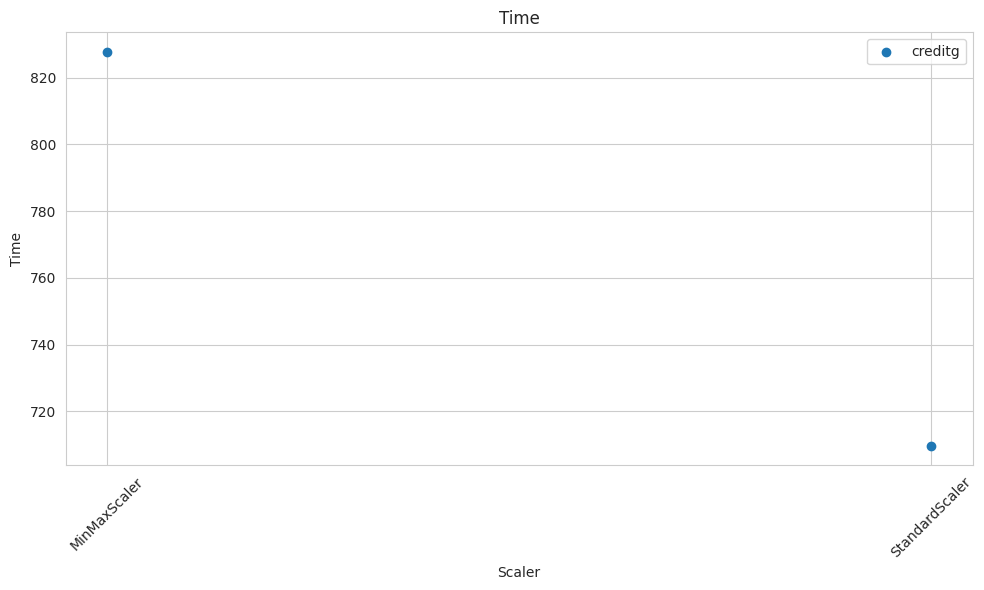

In [20]:
reload(evaluator)
hyperparameters = {
    'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-3,
    'hidden_layer_sizes': (7, ),
    #'random_state': 7895,
    'max_iter': 2500,
    'verbose': False,
    #'tol': 5e-5
}

scaler_result=evaluator.evaluate_scaler(MLPClassifier, X_train=[X_train, X_train_std], y_train=[y_train, y_train], X_test=[X_test, X_test_std], y_test=[y_test, y_test], hyperparameters=hyperparameters, names=['MinMaxScaler', 'StandardScaler'], number_of_tests=10)
evaluator.draw_diagram2_list({"creditg": scaler_result}, x_axis='scaler', y_axis=['f1', 'time'], logaritmic=False, line=False)

In [21]:
combined_results_creditg = {
    # NN
    'nn_learning_rate': nn_learning_rate,
    'nn_hidden_layer': nn_hidden_layer,
    'nn_max_iter': nn_max_iter,
    'nn_hidden_layer_deep': nn_hidden_layer_deepness,
    'act_function': act_function1,
    # RF
    'rf_n_estimators': rf_n_estimators,
    'rf_criterion': rf_criterion,
    # Bayes
    'bayes_results': bayes_results,
    'scaler_result': scaler_result
}
import pickle
with open('creditg_results.pkl', 'wb') as f:
    pickle.dump(combined_results_creditg, f)

In [13]:
import pickle
with open('creditg_results2.pkl', 'rb') as f:
    cr = pickle.load(f)
    cr["nn_learning_rate"] = nn_learning_rate
with open('creditg_results3.pkl', 'wb') as f:
    pickle.dump(cr, f)

In [22]:
# compare classifiers

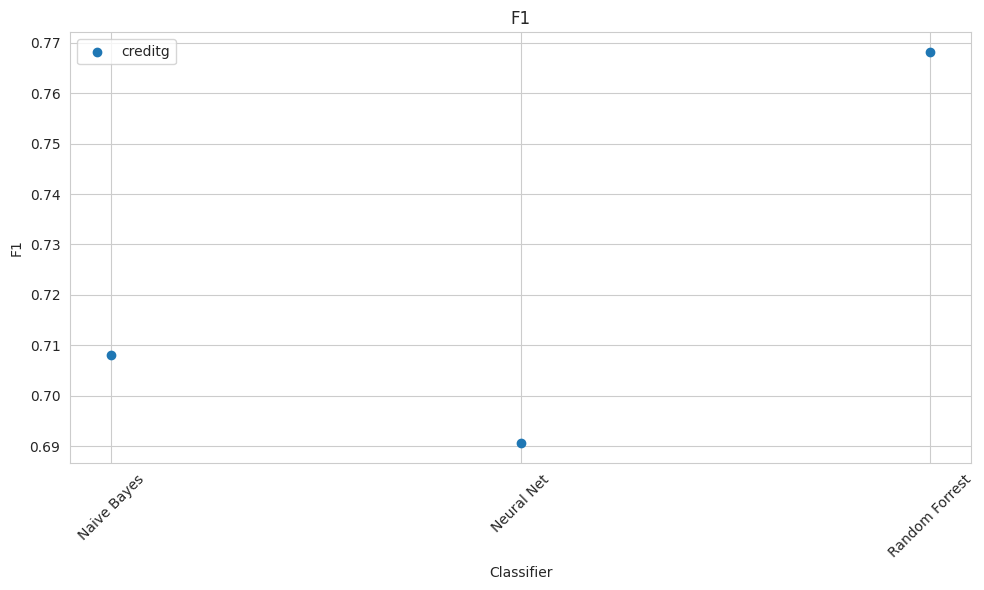

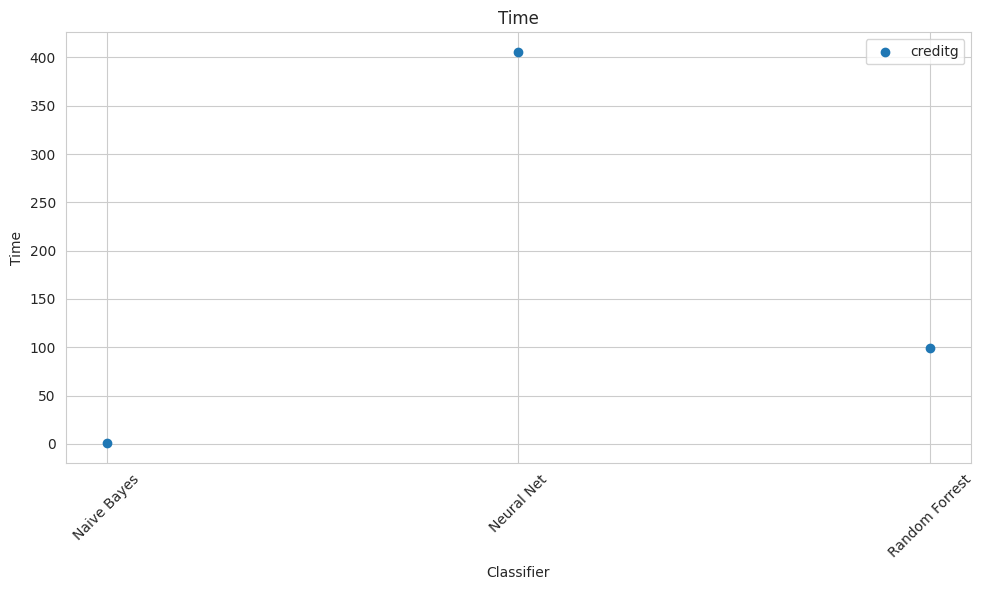

In [23]:
reload(evaluator)

classifiers = [MLPClassifier, RandomForestClassifier, GaussianNB]
names = ['Neural Net', 'Random Forrest', 'Naive Bayes']

hp = [{
        'solver': 'adam',
    'activation': 'relu',
    'learning_rate': 'constant',
    'learning_rate_init': 1e-4,
    'hidden_layer_sizes': (7, 7),
    #'random_state': 7895,
    'max_iter': 2500,
    'verbose': False,
    #'tol': 5e-5
},{
    'n_estimators': 100,
    'criterion': 'gini', # entropy, log_loss
    'verbose': False,
},{
    
}]

clf_res=evaluator.evaluate_classifier(classifiers, X_train, y_train, X_test, y_test, hyperparameters=hp, names=names, number_of_tests=5)
evaluator.draw_diagram2_list({"creditg": clf_res}, x_axis='classifier', y_axis=['f1', 'time'], logaritmic=False, line=False)